In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터 불러오기, 공통 전처리

In [ ]:
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/newdata2.csv', encoding = 'cp949')
raw_data = raw_data[:-1]

# 컬럼 버리기
raw_data = raw_data.drop(raw_data[['현재수위','공용량','잠수교_유량','대곡교_강수량','진관교_강수량','송정동_강수량','서울시_강수량','유입량','저수량']], axis = 1)

# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data.drop(input_y.columns, axis = 1)

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,
2012-05-01 00:00:00,0.058462,0.191781,0.010527,0.147596,0.011070,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.058447,0.199253,0.011332,0.147654,0.011070,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.057689,0.209215,0.011129,0.147478,0.011070,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.058462,0.219178,0.010726,0.147478,0.011475,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.058451,0.232877,0.010726,0.146810,0.011883,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.046624,0.458281,0.006375,0.106425,0.025719,0.0,0.0,0.0,0.0
2022-07-18 23:20:00,0.046621,0.488169,0.006213,0.097370,0.026815,0.0,0.0,0.0,0.0
2022-07-18 23:30:00,0.046620,0.515567,0.008259,0.092994,0.027929,0.0,0.0,0.0,0.0


## train / test data 생성

In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  432 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:30<00:00, 30.08s/it]


In [ ]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))
ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(264672, 432, 5)
(264672, 4)
(6912, 432, 5)
(6912, 4)


## 모델 정의

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

In [ ]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

In [ ]:
model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 424, 64)           2944      
                                                                 
 conv1d_1 (Conv1D)           (None, 414, 64)           45120     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 207, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 13248)             0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 13248)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 200)               1

In [ ]:
#!pip install pydot

In [ ]:
#!pip install graphviz

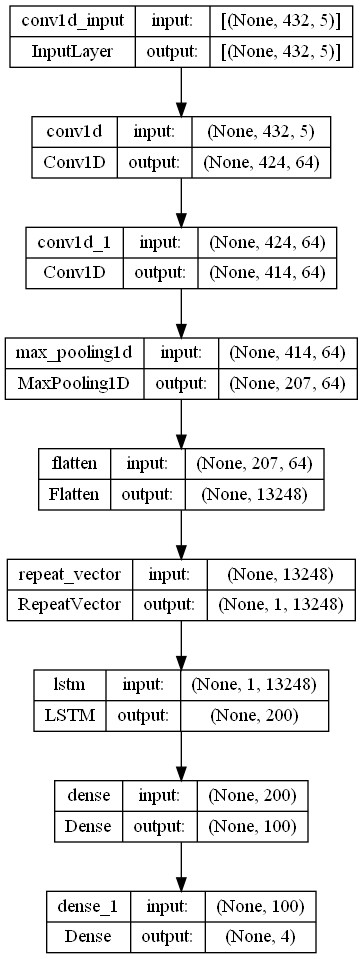

In [ ]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 256
validation = 0.2

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

## 실험용 data 만들기

In [ ]:
#np.random.seed(0)
#small_data_num = 10000
#samll_data = np.random.randint(0,xtrain.shape[0],small_data_num)

#xtrain_ = xtrain[samll_data]
#ytrain_ = ytrain[samll_data]

In [ ]:
#xtrain[0]

array([[0.058462  , 0.19178082, 0.01052695, 0.14759571, 0.01107007],
       [0.05844706, 0.1992528 , 0.01133247, 0.14765402, 0.01107007],
       [0.05768908, 0.20921544, 0.0111288 , 0.1474784 , 0.01107007],
       ...,
       [0.05001587, 0.28268991, 0.0086218 , 0.13286707, 0.0106703 ],
       [0.05023244, 0.26774595, 0.00899047, 0.13315827, 0.01027492],
       [0.04996359, 0.25280199, 0.00880544, 0.13389963, 0.00988426]])

## 학습

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

## 평가

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [ ]:
yhat = keras_model_best.predict(xtest, verbose=1)

216/216 [==============================] - 9s 39ms/step


In [ ]:
yhat

array([[285.47693, 277.6797 , 276.30573, 271.78452],
       [285.54684, 277.6444 , 276.10406, 271.26596],
       [285.75653, 277.69394, 275.9487 , 270.637  ],
       ...,
       [317.4201 , 312.03082, 315.9208 , 326.42395],
       [325.96933, 319.1515 , 321.42395, 324.71478],
       [334.3471 , 325.96548, 326.57248, 322.5612 ]], dtype=float32)

In [ ]:
keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 9s 40ms/step - loss: 7.8401 - accuracy: 0.9019


[7.840086936950684, 0.9019097089767456]

## 학습 과정 시각화

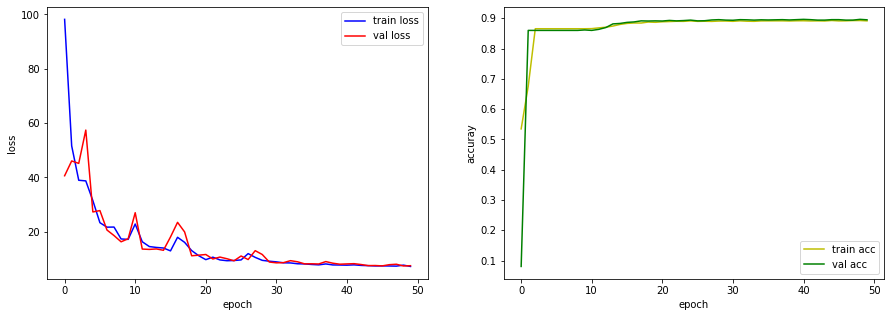

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [ ]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(11.10648545627242, shape=(), dtype=float64)
tf.Tensor(8.0442133041712, shape=(), dtype=float64)
tf.Tensor(8.019729002351335, shape=(), dtype=float64)
tf.Tensor(10.591199084242357, shape=(), dtype=float64)
최종점수:  9.440406711759326


## 점수 확인

In [ ]:
sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("0823 CNN-LSTM.csv", index = False)